# 01 PyTorch Workflow Fundamentals

We're going to get torch, torch.nn (nn stands for neural network and this package contains the building blocks for creating neural networks in PyTorch) and matplotlib.

In [31]:
import torch
from torch import nn  #nn contains all of PyTorch buiding block for neural networks

import matplotlib.pyplot as plt

#check Pytorch version
torch.__version__


'2.9.1+cu128'

`1. Data (Preparing and loading)`
I want to stress that "data" in machine learning can be almost anything you can imagine. A table of numbers (like a big Excel spreadsheet), images of any kind, videos (YouTube has lots of data!), audio files like songs or podcasts, protein structures, text and more.

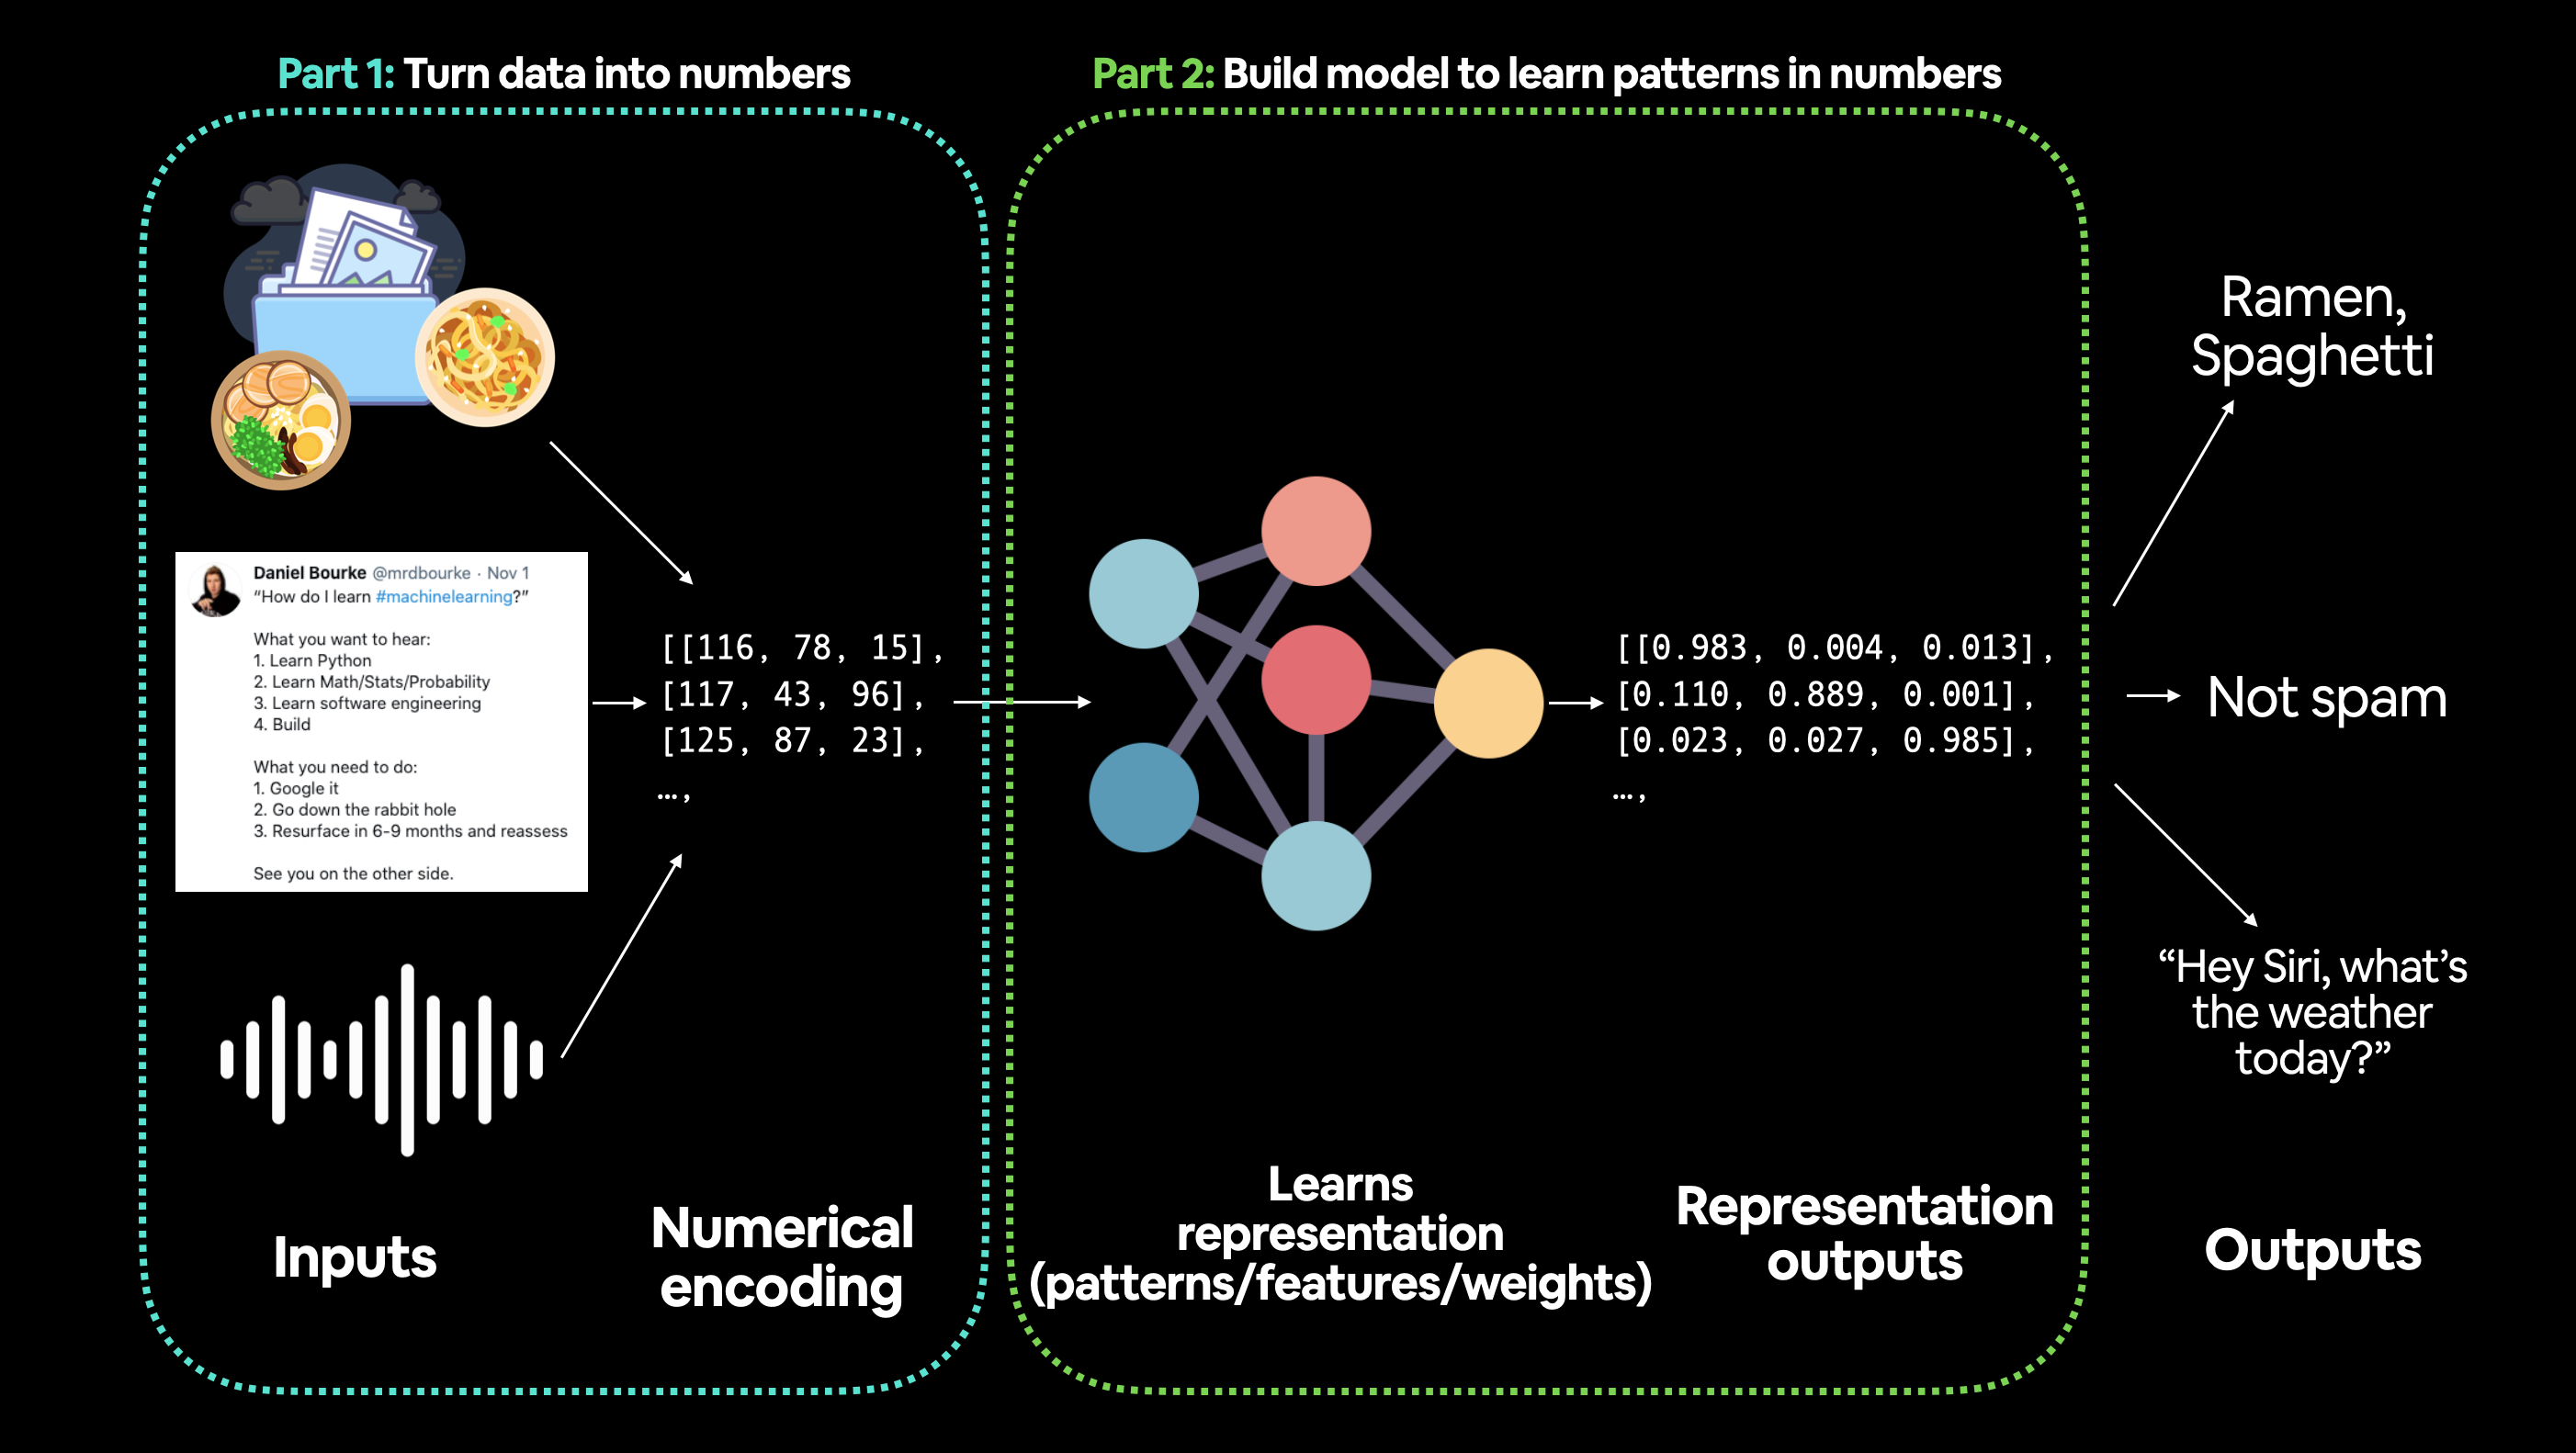

In [32]:
# Create 'Known* parameters

weight = 0.7
bias = 0.3

#Create data
start =0
end=1
step=0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Beatiful! Now we're going to move towards bulding a model that can learn the relationship between x(features) and y(labels)

`Split data into training and test sets`

In [33]:
# Create train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Lets create a function to visualize it

In [34]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    plt.figure(figsize=(10,7))

    #plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    #plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # show the legend
    plt.legend(prop={"size": 14})

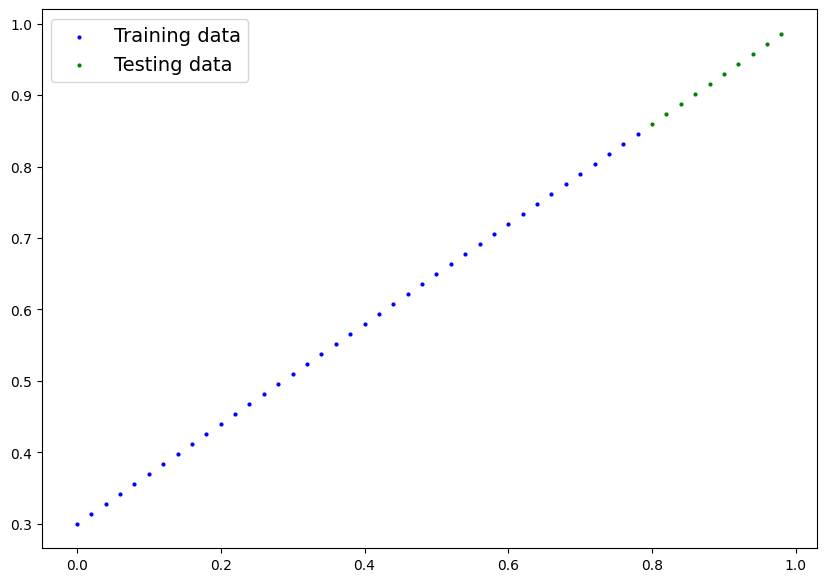

In [35]:
plot_prediction()

### Lets replicate a Linear Regression model using PyTorch

In [36]:
# Create a Linear Regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, 
                                                dtype=torch.float),
                                    requires_grad=True)
        
        
        self.bias = nn.Parameter(torch.randn(1,
                                             dtype=torch.float),
                                             requires_grad=True)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias


## PyTorch model building essentials

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from torch.nn,

* nn.Module contains the larger building blocks (layers)
* nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
* forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
* torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

Checking the contetns of a PyTorch model

In [37]:
# Set manual seed nn.Parameter are randommly initialized

torch.manual_seed(42)

#Create an instace of the model (this is a subclass of nn.Module that containes nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can also get the state (what the model containes) of the model using .state_dict()

In [38]:
# List named parameter
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

`Making Predictions using torch.inference_mode()`

To check this we can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

In [39]:
## Make predictions with model

with torch.inference_mode():
    y_preds = model_0(X_test)

In [40]:
# Check the predictions

print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")

print(f"Predicted values:\n {y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
 tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


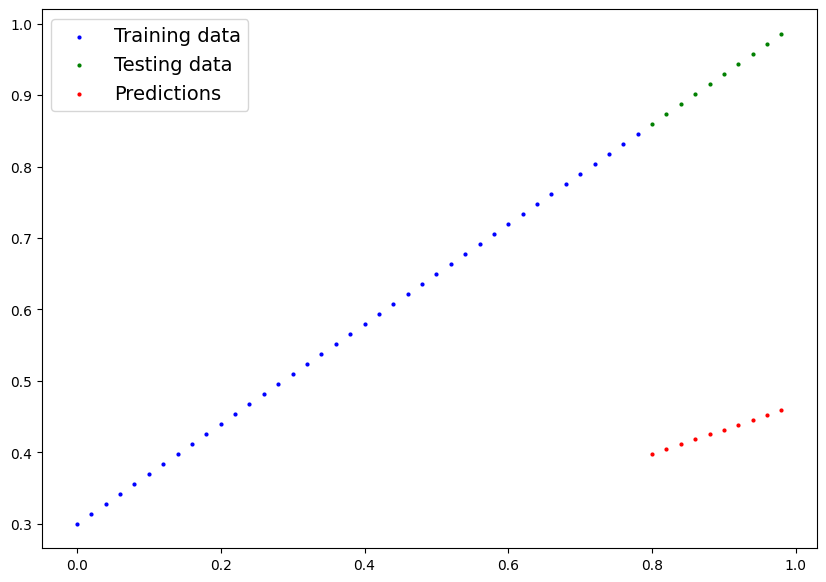

In [41]:
plot_prediction(predictions=y_preds)

In [42]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

`3. Train Model`

In [43]:
# Create the loss function
loss_fn = nn.L1Loss() #MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

## PyTorch training loop

* Forward pass -> The model goes through all of the training data onece, performing its forward() function calculations.

* calculate the loss -> the models outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.

* Zero gradients -> THe optimizers gadients are set to zero (tesy are accumulated by default) so they can be recalculated for the specific training step.

* Perform backpropogation on the loss -> Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with required_grad=True). Thise is known as backpropagation, hence "backwards".

* Update the optimizer (gradient decent) -> Update the parameters with require_grad= True with respect to the loss gradients in oeder to improve them.

## PyTorch testing loop

* Forward pass -> THe model goes through all of the testing data once, performing its forward() function calculations.

* Calculate the loss -> THe models oututs (predictions) are compared to the ground truth and evaluated to see how wrong they are.

* Calculate evaluation metrics(optional) -> Alongside the loss value you many want to caluculate other evaluation metrics such as accuracy on the test set.

In [44]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epoches = 1000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []


for epoch in range(epoches):

    model_0.train()

    #1. Put model in training mode(thise is the default state of a model)
    y_pred = model_0(X_train)
    # print(y_pred)

    #2. calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    #  3. Zero grad of the optimizer
    optimizer.zero_grad()

    #4. Loss backwards
    loss.backward()

    # 5 Progress the optimizer
    optimizer.step()

    # Testing

    model_0.eval()

    with torch.inference_mode():
        # 1. Forward pass on the test data
        test_pred = model_0(X_test)

        #2. Calculate loss on the test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))


        #Print out what happening

        if epoch % 10 ==0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())

            print(f"Epoch: {epoch} | MAE Train loss: {loss} | MAE Test LOss: {test_loss}")

Epoch: 0 | MAE Train loss: 0.31288138031959534 | MAE Test LOss: 0.48106518387794495
Epoch: 10 | MAE Train loss: 0.1976713240146637 | MAE Test LOss: 0.3463551998138428
Epoch: 20 | MAE Train loss: 0.08908725529909134 | MAE Test LOss: 0.21729660034179688
Epoch: 30 | MAE Train loss: 0.053148526698350906 | MAE Test LOss: 0.14464017748832703
Epoch: 40 | MAE Train loss: 0.04543796554207802 | MAE Test LOss: 0.11360953003168106
Epoch: 50 | MAE Train loss: 0.04167863354086876 | MAE Test LOss: 0.09919948130846024
Epoch: 60 | MAE Train loss: 0.03818932920694351 | MAE Test LOss: 0.08886633068323135
Epoch: 70 | MAE Train loss: 0.03476089984178543 | MAE Test LOss: 0.0805937647819519
Epoch: 80 | MAE Train loss: 0.03132382780313492 | MAE Test LOss: 0.07232122868299484
Epoch: 90 | MAE Train loss: 0.02788739837706089 | MAE Test LOss: 0.06473556160926819
Epoch: 100 | MAE Train loss: 0.024458957836031914 | MAE Test LOss: 0.05646304413676262
Epoch: 110 | MAE Train loss: 0.021020207554101944 | MAE Test LOss:

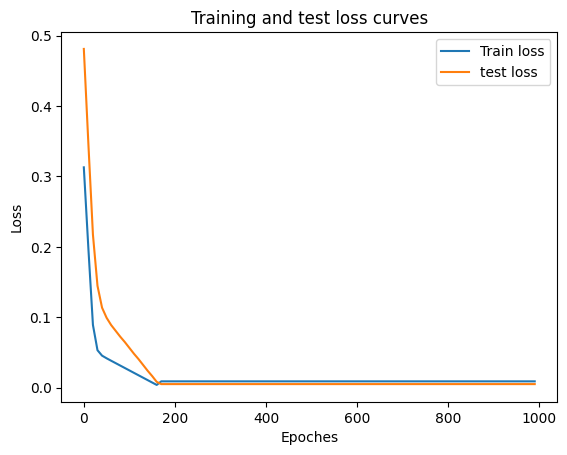

In [45]:
# Plot the loss curve

plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoches")
plt.legend()

In [46]:
# Find our models learned parameters

print("THe model learned the following values for weights and bias:")
print(model_0.state_dict())

print("\nAnd the original values foe weights and bias are:")
print(f"Weights: {weight}, bias: {bias}")

THe model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})

And the original values foe weights and bias are:
Weights: 0.7, bias: 0.3


## Making predictions with a trained PyTorch model(inference)

In [47]:
# 1. set the model in evaluation mode

model_0.eval()

#2. Setup the inferance mode context manager

with torch.inference_mode():
    # make sure the calculation are done with the model and data on the same device
    #in out case, we havent setup device-agnostic code yet so our data and model are
    #on the CPU by default.
    #model_0.to(device)

    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

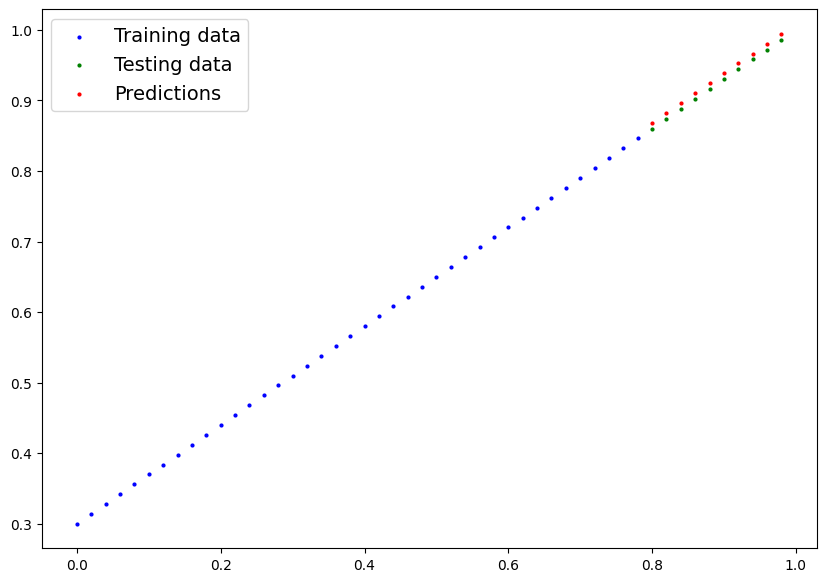

In [48]:
plot_prediction(predictions=y_preds)

## 5. Saving and loading a PYTorch model

* torch.save -> Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

* torch.load -> Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

* torch.nn.Module.load_state_dict -> Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

`Saving PyTorch models state_dict()`

In [49]:
from pathlib import Path

# 1 create models directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2. Create model save path
MODEL_NAME = "01_Pytorch_workflow_model_0.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. save the model state dict

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_Pytorch_workflow_model_0.pth


In [50]:
# Check the saved file path

!ls -l models/01_pytorch_workflow_model_0.pth

ls: cannot access 'models/01_pytorch_workflow_model_0.pth': No such file or directory


## Loading a saved PyTorch models state_dict()

In [51]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

#Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [52]:
# 1.Put the loaded model into evaluation mode
loaded_model_0.eval()

#2 use the inference mode context manager to make predictions

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the data with the loaded model
    

In [53]:
#Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

# Putting it all together

In [54]:
# Import PyTorch and matplotlib

import torch

from torch import nn

import matplotlib.pyplot as plt
# Check Pytorch version
torch.__version__

'2.9.1+cu128'

In [55]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


`6.1 Data`

In [56]:
# Create weight and bias

weight = 0.7
bias = 0.3

# Create range values
start = 0
end =1
step=0.02

#Create X and y (feature and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [57]:
# Split data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

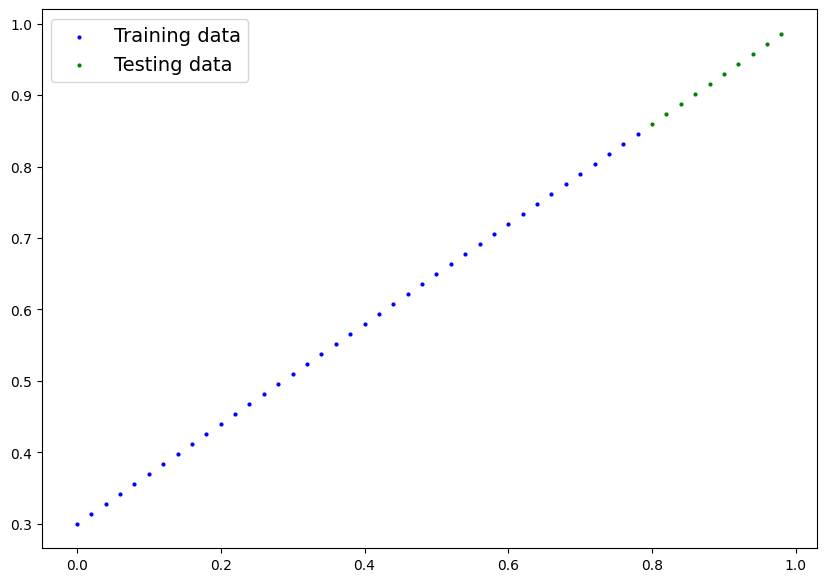

In [58]:
plot_prediction(X_train,y_train,X_test,y_test)

# 6.2 Building a PyTorch linear model

In [62]:
# Subclass nn.module to make our model

class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
        def forward(self, x:torch.Tensor) -> torch.Tensor:
            return self.linear_layer(x)
        
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [63]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [64]:
# Set model to GPU if it's availabel 

model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

`6.3 Training`

In [65]:
# Create loss function
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000 

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")